# Minería de Redes Sociales + Métricas de Desempeño

**Alumno:** Deyvis Quispe Mamani

**Tema:** Redes Sociales — pipeline (EDA ➜ Clasificación de sentimiento ➜ Red de menciones ➜ Influencers (PageRank/Betweenness) ➜ Comunidades (modularidad) ➜ Sentimiento por comunidad ➜ Visualización).
---


In [1]:
# !pip install networkx==3.2.1 scikit-learn==1.3.2 matplotlib==3.8.4 plotly==5.24.1

import re, html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# Ruta al CSV
PATH = '/content/social_posts.csv'

df = pd.read_csv(PATH)
print(df.shape)
df.head()


(1200, 6)


,post_id,platform,author,text,sentiment,created_at
0,1,Twitter,user115,"Pésima experiencia con @equipoY, no lo recomie...",negative,2024-05-15 02:58:00
1,2,Twitter,user433,"Gracias @soporteX por el apoyo, quedé feliz co...",positive,2024-04-20 22:10:00
2,3,YouTube,user559,"Recomiendo a @devTips, contenido de calidad y ...",positive,2024-04-17 23:49:00
3,4,TikTok,user433,"Recomiendo a @soporteX, contenido de calidad y...",positive,2024-04-17 20:36:00
4,5,Twitter,user271,"Malo el soporte de @fitLife, aún espero respue...",negative,2024-07-04 21:27:00


## 1) Carga de datos + EDA mínima

In [2]:
# EDA rápida
display(df.sample(5))
print("\nPlataformas:", df['platform'].value_counts().to_dict())
print("\nEtiquetas de sentimiento:", df['sentiment'].value_counts().to_dict())

# Limpieza mínima (sin tocar menciones, URLs ni hashtags en texto — se usan después)
def light_clean(s: str) -> str:
    s = re.sub(r"http\S+", "", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df['text_clean'] = df['text'].astype(str).apply(light_clean)
df[['text', 'text_clean']].head()


,post_id,platform,author,text,sentiment,created_at
1120,1121,TikTok,user67,"Buenísimo el video de @fotografia, 10/10 y gra...",positive,2024-03-30 18:36:00
332,333,TikTok,user467,"Gracias @devTips por el apoyo, quedé feliz con...",positive,2024-02-25 19:35:00
619,620,YouTube,user160,Actualización de @fitLife disponible,neutral,2024-03-20 01:54:00
599,600,Twitter,user93,"Qué gran atención de @devTips, todo rápido y c...",positive,2024-04-30 00:51:00
138,139,Twitter,user571,"No funciona lo que vende @modaTrends, una esta...",negative,2024-04-01 11:35:00



Plataformas: {'Twitter': 309, 'TikTok': 300, 'Instagram': 297, 'YouTube': 294}

Etiquetas de sentimiento: {'positive': 545, 'negative': 388, 'neutral': 267}


,text,text_clean
0,"Pésima experiencia con @equipoY, no lo recomie...","Pésima experiencia con @equipoY, no lo recomie..."
1,"Gracias @soporteX por el apoyo, quedé feliz co...","Gracias @soporteX por el apoyo, quedé feliz co..."
2,"Recomiendo a @devTips, contenido de calidad y ...","Recomiendo a @devTips, contenido de calidad y ..."
3,"Recomiendo a @soporteX, contenido de calidad y...","Recomiendo a @soporteX, contenido de calidad y..."
4,"Malo el soporte de @fitLife, aún espero respue...","Malo el soporte de @fitLife, aún espero respue..."


## 2)Clasificación de sentimiento (TF-IDF + Regresión Logística) y métricas

In [3]:
X = df['text_clean'].values
y = df['sentiment'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2), min_df=2)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

clf = LogisticRegression(max_iter=300, n_jobs=None)
clf.fit(Xtr, y_train)

y_pred = clf.predict(Xte)
print(classification_report(y_test, y_pred))

# Probabilidades para AUC
from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
y_proba = clf.predict_proba(Xte)

try:
    auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print("ROC-AUC (macro, OVR):", round(auc, 3))
except Exception as e:
    print("AUC no disponible:", e)


              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        78
     neutral       1.00      1.00      1.00        53
    positive       1.00      1.00      1.00       109

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240

ROC-AUC (macro, OVR): 1.0


## 3) Red de menciones (autor → mencionado)

Nodos: 550 - Aristas: 1543


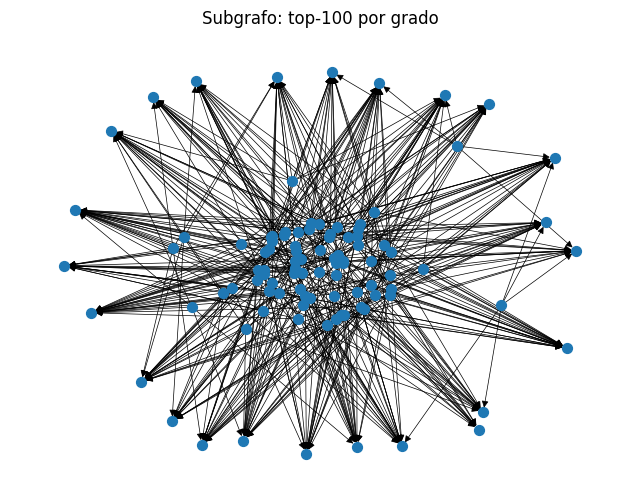

In [4]:
# Extraccion de menciones tipo @usuario y construccion del grafo dirigido
def extract_mentions(text: str):
    if not isinstance(text, str):
        return []
    # patrón: menciones @palabra
    return re.findall(r"@([A-Za-z0-9_]+)", text)

df['mentions'] = df['text'].apply(extract_mentions)

G = nx.DiGraph()
for _, row in df.iterrows():
    author = row['author']
    mentions = row['mentions']
    for m in mentions:
        if author and m:
            G.add_edge(author, m.lower())

print(f'Nodos: {G.number_of_nodes()} - Aristas: {G.number_of_edges()}')

# Subgrafo de los 100 nodos con mayor grado (entrante+saliente)
degree_dict = dict(G.degree())
top_nodes = [n for n, _ in sorted(degree_dict.items(), key=lambda kv: kv[1], reverse=True)[:100]]
H = G.subgraph(top_nodes).copy()

plt.figure(figsize=(8,6))
pos = nx.spring_layout(H, seed=42)
nx.draw_networkx(H, pos=pos, node_size=50, with_labels=False, width=0.5)
plt.title("Subgrafo: top-100 por grado")
plt.axis("off")
plt.show()


## 4) Influencers: PageRank + Betweenness + Grado (in/out)

In [5]:
pagerank = nx.pagerank(G)
betw = nx.betweenness_centrality(G, normalized=True)

in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

import pandas as pd
rank_df = pd.DataFrame({
    'node': list(G.nodes()),
    'pagerank': [pagerank.get(n, 0) for n in G.nodes()],
    'betweenness': [betw.get(n, 0) for n in G.nodes()],
    'in_degree': [in_degree.get(n, 0) for n in G.nodes()],
    'out_degree': [out_degree.get(n, 0) for n in G.nodes()],
})
rank_df = rank_df.sort_values(['pagerank','betweenness','in_degree'], ascending=False)
print("Top 15 influencers:")
display(rank_df.head(15))


Top 15 influencers:


,node,pagerank,betweenness,in_degree,out_degree
58,hogarideas,0.024777,0.0,80,0
42,saludplus,0.024024,0.0,75,0
14,ofertashoy,0.023623,0.0,66,0
7,cinefan,0.022622,0.0,72,0
68,foodlover,0.021737,0.0,64,0
1,equipoy,0.021516,0.0,67,0
81,fotografia,0.021265,0.0,65,0
6,devtips,0.020831,0.0,74,0
45,brandz,0.020181,0.0,65,0
40,brandx,0.020116,0.0,63,0


## 5) Comunidades sobre grafo no dirigido

In [6]:
Gu = G.to_undirected()

from networkx.algorithms.community import greedy_modularity_communities
comms = list(greedy_modularity_communities(Gu))
print("Comunidades detectadas:", len(comms))

# Mapa nodo -> id de comunidad
comm_id = {}
for i, cset in enumerate(comms):
    for n in cset:
        comm_id[n] = i

# Tamaños
sizes = pd.Series([len(c) for c in comms]).sort_values(ascending=False)
sizes.head(10)


Comunidades detectadas: 10


,0
0,82
1,70
2,65
3,56
4,54
5,52
6,49
7,46
8,42
9,34


## 6) Sentimiento medio por comunidad (NLP + SNA)

In [7]:
# Mapeamos sentimiento a números (-1, 0, +1)
sent_map = {'negative': -1, 'neutral': 0, 'positive': 1}
df['sent_num'] = df['sentiment'].map(sent_map).fillna(0)

# Se asigna comunidad al autor cuando exista
df['author_comm'] = df['author'].map(comm_id)

comm_sent = (
    df.dropna(subset=['author_comm'])
      .groupby('author_comm')['sent_num']
      .agg(n_tweets='count', sent_mean='mean')
      .sort_values('sent_mean')
)
display(comm_sent.head(15))


,n_tweets,sent_mean
author_comm,,
8,77,-0.025974
6,105,0.066667
2,146,0.075342
4,114,0.114035
5,116,0.137931
3,130,0.138462
0,182,0.164835
1,157,0.165605
9,78,0.205128


## 7) Visualización ligera (subgrafo top-N)

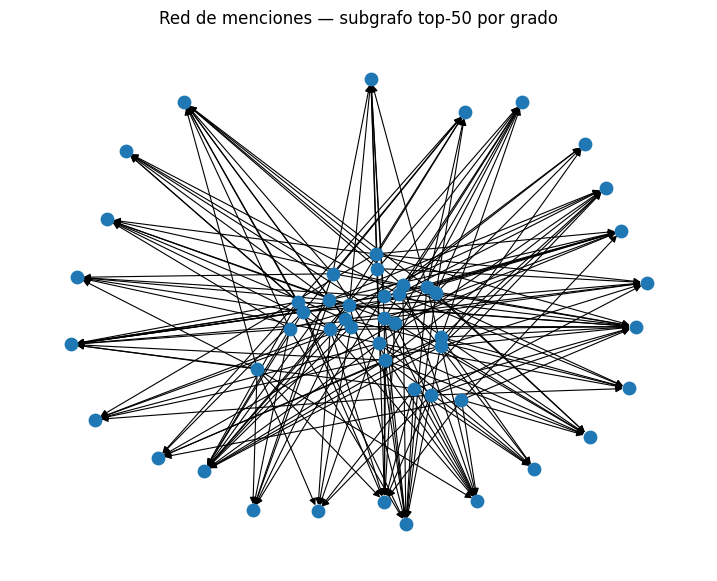

In [8]:
N = 50  # top-N por grado para graficar
deg = dict(G.degree())
top_nodes = [n for n, _ in sorted(deg.items(), key=lambda kv: kv[1], reverse=True)[:N]]
H = G.subgraph(top_nodes).copy()

pos = nx.spring_layout(H, seed=42)
plt.figure(figsize=(9,7))
nx.draw_networkx(H, pos=pos, node_size=80, with_labels=False, width=0.8)
plt.title(f"Red de menciones — subgrafo top-{N} por grado")
plt.axis("off")
plt.show()
